### The scripts presented here is clean and automates employee attrition model
<br/> The script imports the data, preprocess it, test 3 models and chooses the model with the highest precision to make a prediction
<br/> _Author **Shereef Bankole**_
<br/> **LinkedIn click** <a href="https://www.linkedin.com/in/shereef-b-b9aab823/">Here<a/>
<br/> **Github click**  <a href= "https://github.com/SAB-6">Here<a/>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplot
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, confusion_matrix, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.metrics import precision_score
%matplotlib inline

In [2]:
def import_data(filename):
    '''This function reads a csv file'''
    raw_data=pd.read_csv(filename)
    return raw_data

In [3]:
def Heat_map(data, features):
    '''This function generates heatmap taking data and featuresas inputs'''
    plt.figure(figsize=(20, 10))
    sns.heatmap(data[features].corr(), cmap='RdBu', annot=True)
    plt.xticks(rotation=45) 
    plt.title('Heatmap of Correlation Matrix')

In [4]:
def get_dummie(data, drop_cols=None):
    '''This function performs onehotencoding on categorical features and merge them numerical features'''
#it requires the data and any column features to drop out form the data as inputs
    attrition={'Yes':1, 'No':0}
    print(data.columns)
    data.Attrition=[attrition[item] for item in data.Attrition]
    cat_var=[]
    num_var=[]
    for column in data:
        if data[column].dtypes=='O':
            cat=column
            cat_var.append(cat)
        elif column== 'Attrition': continue
    
        else:
            num=column
            num_var.append(num)

    categorical_df = pd.get_dummies(data[cat_var], drop_first=True)
    numerical_df = data[num_var]

    new_data = pd.concat([data['Attrition'],categorical_df,numerical_df], axis=1)
    new_data.drop(drop_cols, axis=1, inplace=True)
    return new_data

In [5]:
def preprocess_data(data):
    '''The function splits the data into training and test sets, standardises the features and take care of sampling imbalance'''
    '''The function returns SMOTE oversampled training_features, training_target, features_test, target_test'''
   
    print('\n standardising the featues\n')
    scaler= StandardScaler()
    # Create the feature and target set
    features = data.iloc[:,1:]
    target  = data.iloc[:,0]
    features=scaler.fit_transform(features)
    
    print('\n splitting data to training and test set\n')
    features_train, features_test, target_train, target_test = train_test_split(features,target,test_size=0.30, random_state=123, stratify=target)
    print('The number of training set is: {}. \nThe number of test set is: {}' .format(features_train.shape,features_test.shape[0]) )
    
    
    print('\n Adjusting sampling imbalance using SMOTE(Synthetic Minority Over-sampling Technique)\n')
    !pip install imblearn
    from imblearn.over_sampling import SMOTE
    
    # Upsample using SMOTE
    sm = SMOTE(random_state=12)
    features_train_sm, target_train_sm = sm.fit_sample(features_train, target_train)
    print('The oversampled training features shape are: {} for the features and {} for the targets: ' .format(features_train_sm.shape, target_train_sm.shape))
    
    return features_train_sm, target_train_sm, features_test, target_test

In [6]:
def Hyperparameter_tunning(model, param_grid):
    '''The function produces the best parameter for selected models'''
    '''TIt takes model and parameters as input and print out the best_parameters for each model'''
    print("\n Hyperameter tunning for: %s" % (model), '\n')
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv = 10)  
    grid_search=grid_search.fit(features_train_sm, target_train_sm)
    print("\n the best_score is: %f using %s \n" % (grid_search.best_score_, grid_search.best_params_))

In [11]:
def class_report(model, target_test, features_test, AUC, prec_score,classification_repo):
    '''Training the models with the best hand tuned ``hyperparameters'''
  
    print ("\n\n --- Training %s---" %(model))
    model=model.fit(features_train_sm,target_train_sm)
    target_pred = model.predict(features_test)
    AUC[model]= (roc_auc_score(target_test, target_pred))
    prec_score[model]= precision_score(target_test, target_pred)
    classification_repo[model]= classification_report(target_test, model.predict(features_test))

In [12]:
def print_results(model, AUC, prec_score, classification_repo):
    print('Results: ')
    #print('\nModel:\n', model)
    print ("\n Area under receiver operating charateristics curve (AUC) \n = {}  \n Precision = {}" .format(AUC[model], prec_score[model]))
    print('Standard deviation of root mean score error is:\n',  classification_repo[model] )

In [40]:
def save_results(model, classification_repo, attrition_prob, feature_importances):
    '''saving model, model summary, classification report, predictions and feature importances'''
    with open('model.txt', 'w') as file:
        file.write(str(model))
    feature_importances.to_csv('feature_importances.csv')
    attrition_prob.to_csv('Attrition_probability.csv')
    with open ('Classification_report.txt', 'w') as file:
        file.write(str(model))
        file.write(str(classification_repo))
    #np.save('classification_report.csv', classification_repo)

In [ ]:
!pwd

In [14]:
#import csv data
filename= 'IBM_HR_Employee_Attrition.csv'
df=import_data(filename)

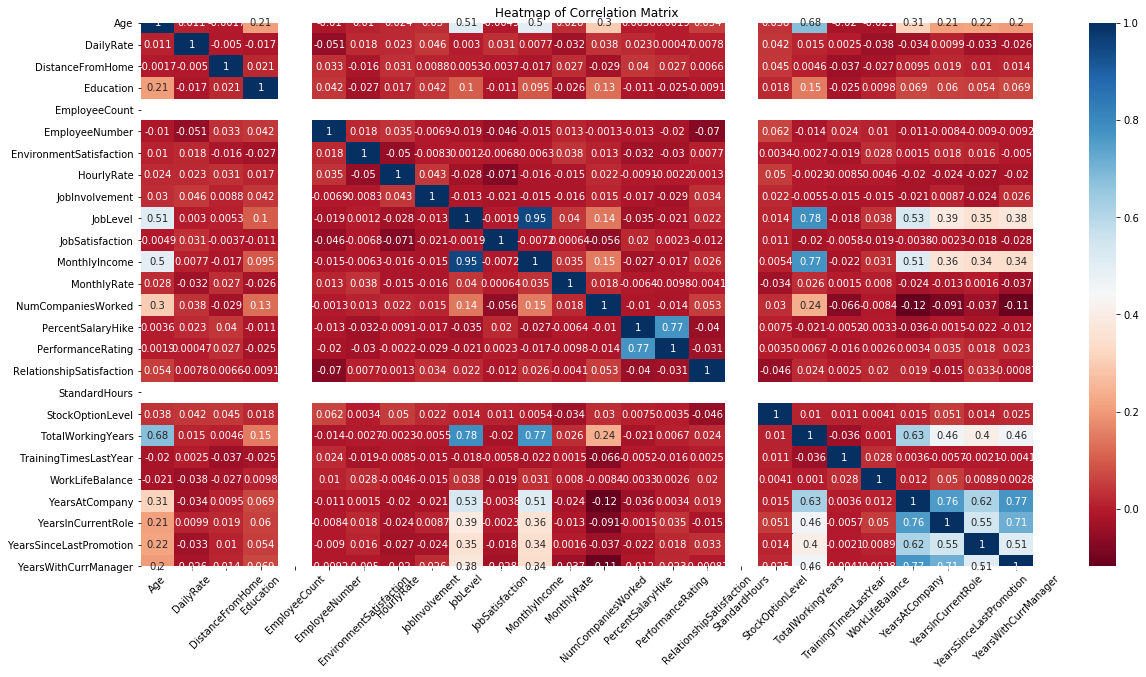

In [15]:
#Creating heat map
features=df.columns
data=df
Heat_map(data, features)

In [17]:
#drop unwanted columns
data_new=get_dummie(data,drop_cols=['StandardHours','EmployeeCount']) 
data_new.head()

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')


,Attrition,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Research & Development,Department_Sales,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,1,0,1,0,1,1,0,0,0,0,...,3,1,0,8,0,1,6,4,0,5
1,0,1,0,1,0,1,0,0,0,0,...,4,4,1,10,3,3,10,7,1,7
2,1,0,1,1,0,0,0,0,1,0,...,3,2,0,7,3,3,0,0,0,0
3,0,1,0,1,0,1,0,0,0,0,...,3,3,0,8,3,3,8,7,3,0
4,0,0,1,1,0,0,0,1,0,0,...,3,4,1,6,3,3,2,2,2,2


In [18]:
#preposess data by taking care of sample imbalance, standardise and split data to training and test sets
features_train_sm, target_train_sm, features_test, target_test=preprocess_data(data_new)


 standardising the featues


 splitting data to training and test set

The number of training set is: (1029, 45). 
The number of test set is: 441

 Adjusting sampling imbalance using SMOTE(Synthetic Minority Over-sampling Technique)

The oversampled training features shape are: (1726, 45) for the features and (1726,) for the targets: 


In [19]:
#initialize model list and dicts
models = []
AUC={}
prec_score= {}
classification_repo={}

In [20]:
#create models -- hyperparameter tuning already done by hand for each model

lr = LogisticRegression(C=1.0, dual=False, max_iter= 100)
rf = RandomForestClassifier(n_estimators=70, max_features='auto',max_depth=15,bootstrap=False, random_state=12)
gbt = GradientBoostingClassifier(max_depth= 25, max_features= 'sqrt', n_estimators=30, random_state=12)

models.extend([lr, rf, gbt])

for model in models:
    class_report(model, target_test, features_test, AUC, prec_score, classification_repo)
    print_results(model, AUC, prec_score, classification_repo)



 --- Training LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)---
Results: 

 Area under receiver operating charateristics curve (AUC) 
 = 0.7610772744575561  
 Precision = 0.3897058823529412
Standard deviation of root mean score error is:
               precision    recall  f1-score   support

           0       0.94      0.78      0.85       370
           1       0.39      0.75      0.51        71

    accuracy                           0.77       441
   macro avg       0.67      0.76      0.68       441
weighted avg       0.85      0.77      0.80       441



 --- Training RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=15, max_feat

In [21]:
#choose model with highest precision
best_model = max(prec_score, key=prec_score.get)
print('\nmaking prediction using model with highest precision score:')
print(best_model)

#train model on entire dataset
best_model.fit(features_train_sm, target_train_sm)

#create predictions based on test data
predictions = best_model.predict(features_test)


making prediction using model with highest precision score:
RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=70,
                       n_jobs=None, oob_score=False, random_state=12, verbose=0,
                       warm_start=False)


In [30]:
#Attrition probability
attrition_prob=pd.DataFrame(best_model.predict_proba(features_test),index=target_test.index, columns=["Attrition", "No_Attrition"]).sort_values(by='Attrition',ascending=False)
attrition_prob

,Attrition,No_Attrition
922,0.985714,0.014286
105,0.985714,0.014286
1299,0.985714,0.014286
907,0.985714,0.014286
812,0.985714,0.014286
...,...,...
689,0.277141,0.722859
683,0.258159,0.741841
14,0.228027,0.771973
1339,0.129478,0.870522


In [41]:
#store feature importances
if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
else:
    
    print(best_model + 'has no feature_importances')
    
feature_importances = pd.DataFrame({'feature':data_new.iloc[:,1:].columns, 'importance':importances})
feature_importances.sort_values(by='importance', ascending=False, inplace=True)
#set index to 'feature'
feature_importances.set_index('feature', inplace=True, drop=True)

classification_repo=classification_report(target_test, best_model.predict(features_test))
#save results
save_results(best_model, classification_repo, attrition_prob, feature_importances)